In [1]:
import hashlib
import os
import zipfile
import tarfile
import requests
from torch.utils import data
from IPython import display
from matplotlib import pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

data_hub = dict()
data_url = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('../..', 'data')):
    assert name in data_hub, f'{name} 不存在于 {data_hub}'
    url, sha1_hash = data_hub[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [4]:
def download_all():
    for name in data_hub:
        download(name)

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn

data_hub['kaggle_house_train'] = (data_url + 'kaggle_house_pred_train.csv',
                                 '585e9cc93e70b39160e7921475f9bcd7d31219ce')
data_hub['kaggle_house_test'] = (data_url + 'kaggle_house_pred_test.csv',
                                'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [6]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [7]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [9]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x -x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                             dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                            dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                           dtype=torch.float32)

loss = nn.MSELoss()
in_features = train_features.shape[1]

In [10]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [11]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs,  learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                            weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for x, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(x), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [13]:
def get_k_fold_data(k, i, x, y):
    assert k > 1
    fold_size = x.shape[0] // k
    x_train, y_train = None, None
    for j in range(k):
        inx = slice(j * fold_size, (j + 1) * fold_size)
        x_part, y_part = x[inx, :], y[inx]
        if j == i:
            x_valid, y_valid = x_part, y_part
        elif x_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat([x_train, x_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return x_train, y_train, x_valid, y_valid

In [14]:
def k_fold(k, x_train, y_train, num_epochs, learning_rate, weight_decay, 
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, x_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                 weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f},',
             f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.169869, valid log rmse 0.157408
fold 2, train log rmse 0.162594, valid log rmse 0.190520
fold 3, train log rmse 0.164304, valid log rmse 0.168844
fold 4, train log rmse 0.167896, valid log rmse 0.154345
fold 5, train log rmse 0.163187, valid log rmse 0.182834
5-折验证：平均训练log rmse: 0.165570,平均验证log rmse: 0.170790


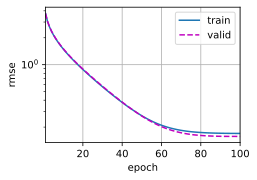

In [15]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                         weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse: {float(train_l):f},'
     f'平均验证log rmse: {float(valid_l):f}')

In [16]:
def train_and_pred(trian_features, test_feature, train_labels, test_data,
                  num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                       num_epochs, lr, weight_decay, batch_size)
    plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
        ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162139


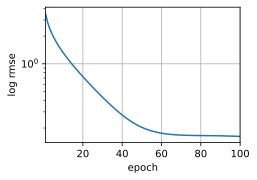

In [17]:
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)